In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import earthpy.spatial as es
import rasterio

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


In [3]:
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 
ext2 = [-175., -120., 50., 75.] # extend of AK
exts = [ext1, ext2]



## Read USGS GMTED2010 7.5 arc second elevation data

In [4]:
## open file and get lats/lons
## adapted from: https://gis.stackexchange.com/questions/388047/get-coordinates-of-all-pixels-in-a-raster-with-rasterio

filename = path_to_data + 'downloads/GMTED/50n150w_20101117_gmted_mea075.tif'
with rasterio.open(filename) as src:
    elev = src.read()
    print('Elevation tif has shape', elev.shape)
    height = elev[0].shape[0]
    width = elev[0].shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    print('lons shape', lons.shape)

Elevation tif has shape (1, 9600, 14400)
lons shape (9600, 14400)


In [5]:
## crop to extent of SEAK
# hacked this: TODO write function to find nearest neighbor idx for lat lon
elev = elev[0, 4500:7500, 4000:9750]
lats = lats[4500:7500, 4000:9750]
lons = lons[4500:7500, 4000:9750]
print(elev.shape, lats.shape, lons.shape)

(3000, 5750) (3000, 5750) (3000, 5750)


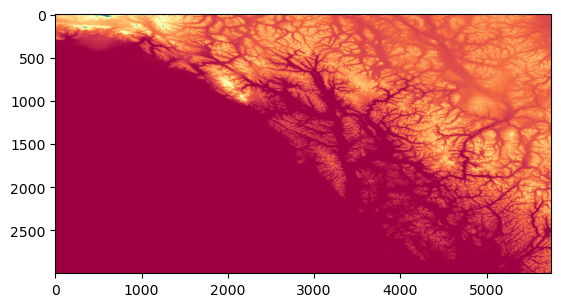

In [6]:
plt.imshow(elev, cmap='Spectral')
plt.show()

### Create hillshade of elevation

In [7]:
hillshade = es.hillshade(elev, azimuth=270, altitude=1)

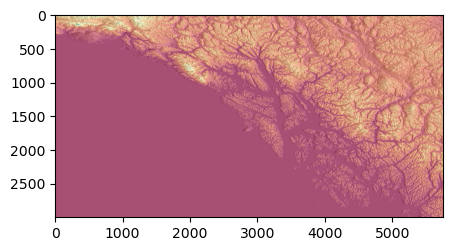

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
i = plt.imshow(elev, cmap='Spectral', alpha=0.8)
ax.imshow(hillshade, cmap="Greys", alpha=0.3)

plt.show()

In [35]:
# put into a xarray dataset
var_dict = {'elev': (['lat', 'lon'], elev),
            'hillshade': (['lat', 'lon'], hillshade)}
ds = xr.Dataset(var_dict,
                coords={'lat': (['lat'], lats[:, 0]),
                        'lon': (['lon'], lons[0, :])})

## add some metadata
ds['elev'].attrs["long_name"] = "Global Multi-resolution Terrain Elevation Data 2010"
ds['elev'].attrs["units"] = "meters"
ds['elev'].attrs["vertical_datum"] = "sea level"
ds['elev'].attrs["datum"] = "WGS84"
ds.attrs["title"] = "USGS GMTED2010 7.5 arc second elevation"
ds.attrs["doi"] = "10.5066/F7J38R2N"
ds['hillshade'].attrs["long_name"] = "Elevation hillshade by Earthpy, Azimuth=270 degrees"

# write to netCDF
fname = path_to_data + 'preprocessed/seak_gmted_mea075.nc'
ds.to_netcdf(path=fname, mode = 'w', format='NETCDF4')

### Read Glacier Shapefile

In [11]:
# fp = path_to_data + '/downloads/Alaska_Glacier_Inventory_RGI/Alaska_Glacier_Inventory_RGI.shp'
# polys = gpd.read_file(fp, bbox=[ext1[0], ext1[3], ext1[1], ext1[2]]) # read shapefile
# crs_polys = ccrs.epsg('3395')
# polys = polys.to_crs("EPSG:3395") # reproject to Mercator

# ## test
# fig, ax = plt.subplots()
# polys.plot(ax=ax, facecolor='c', alpha=0.4);
# plt.tight_layout();

## Station and City Data

In [12]:
## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

## Make Figure

In [22]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Mercator() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)




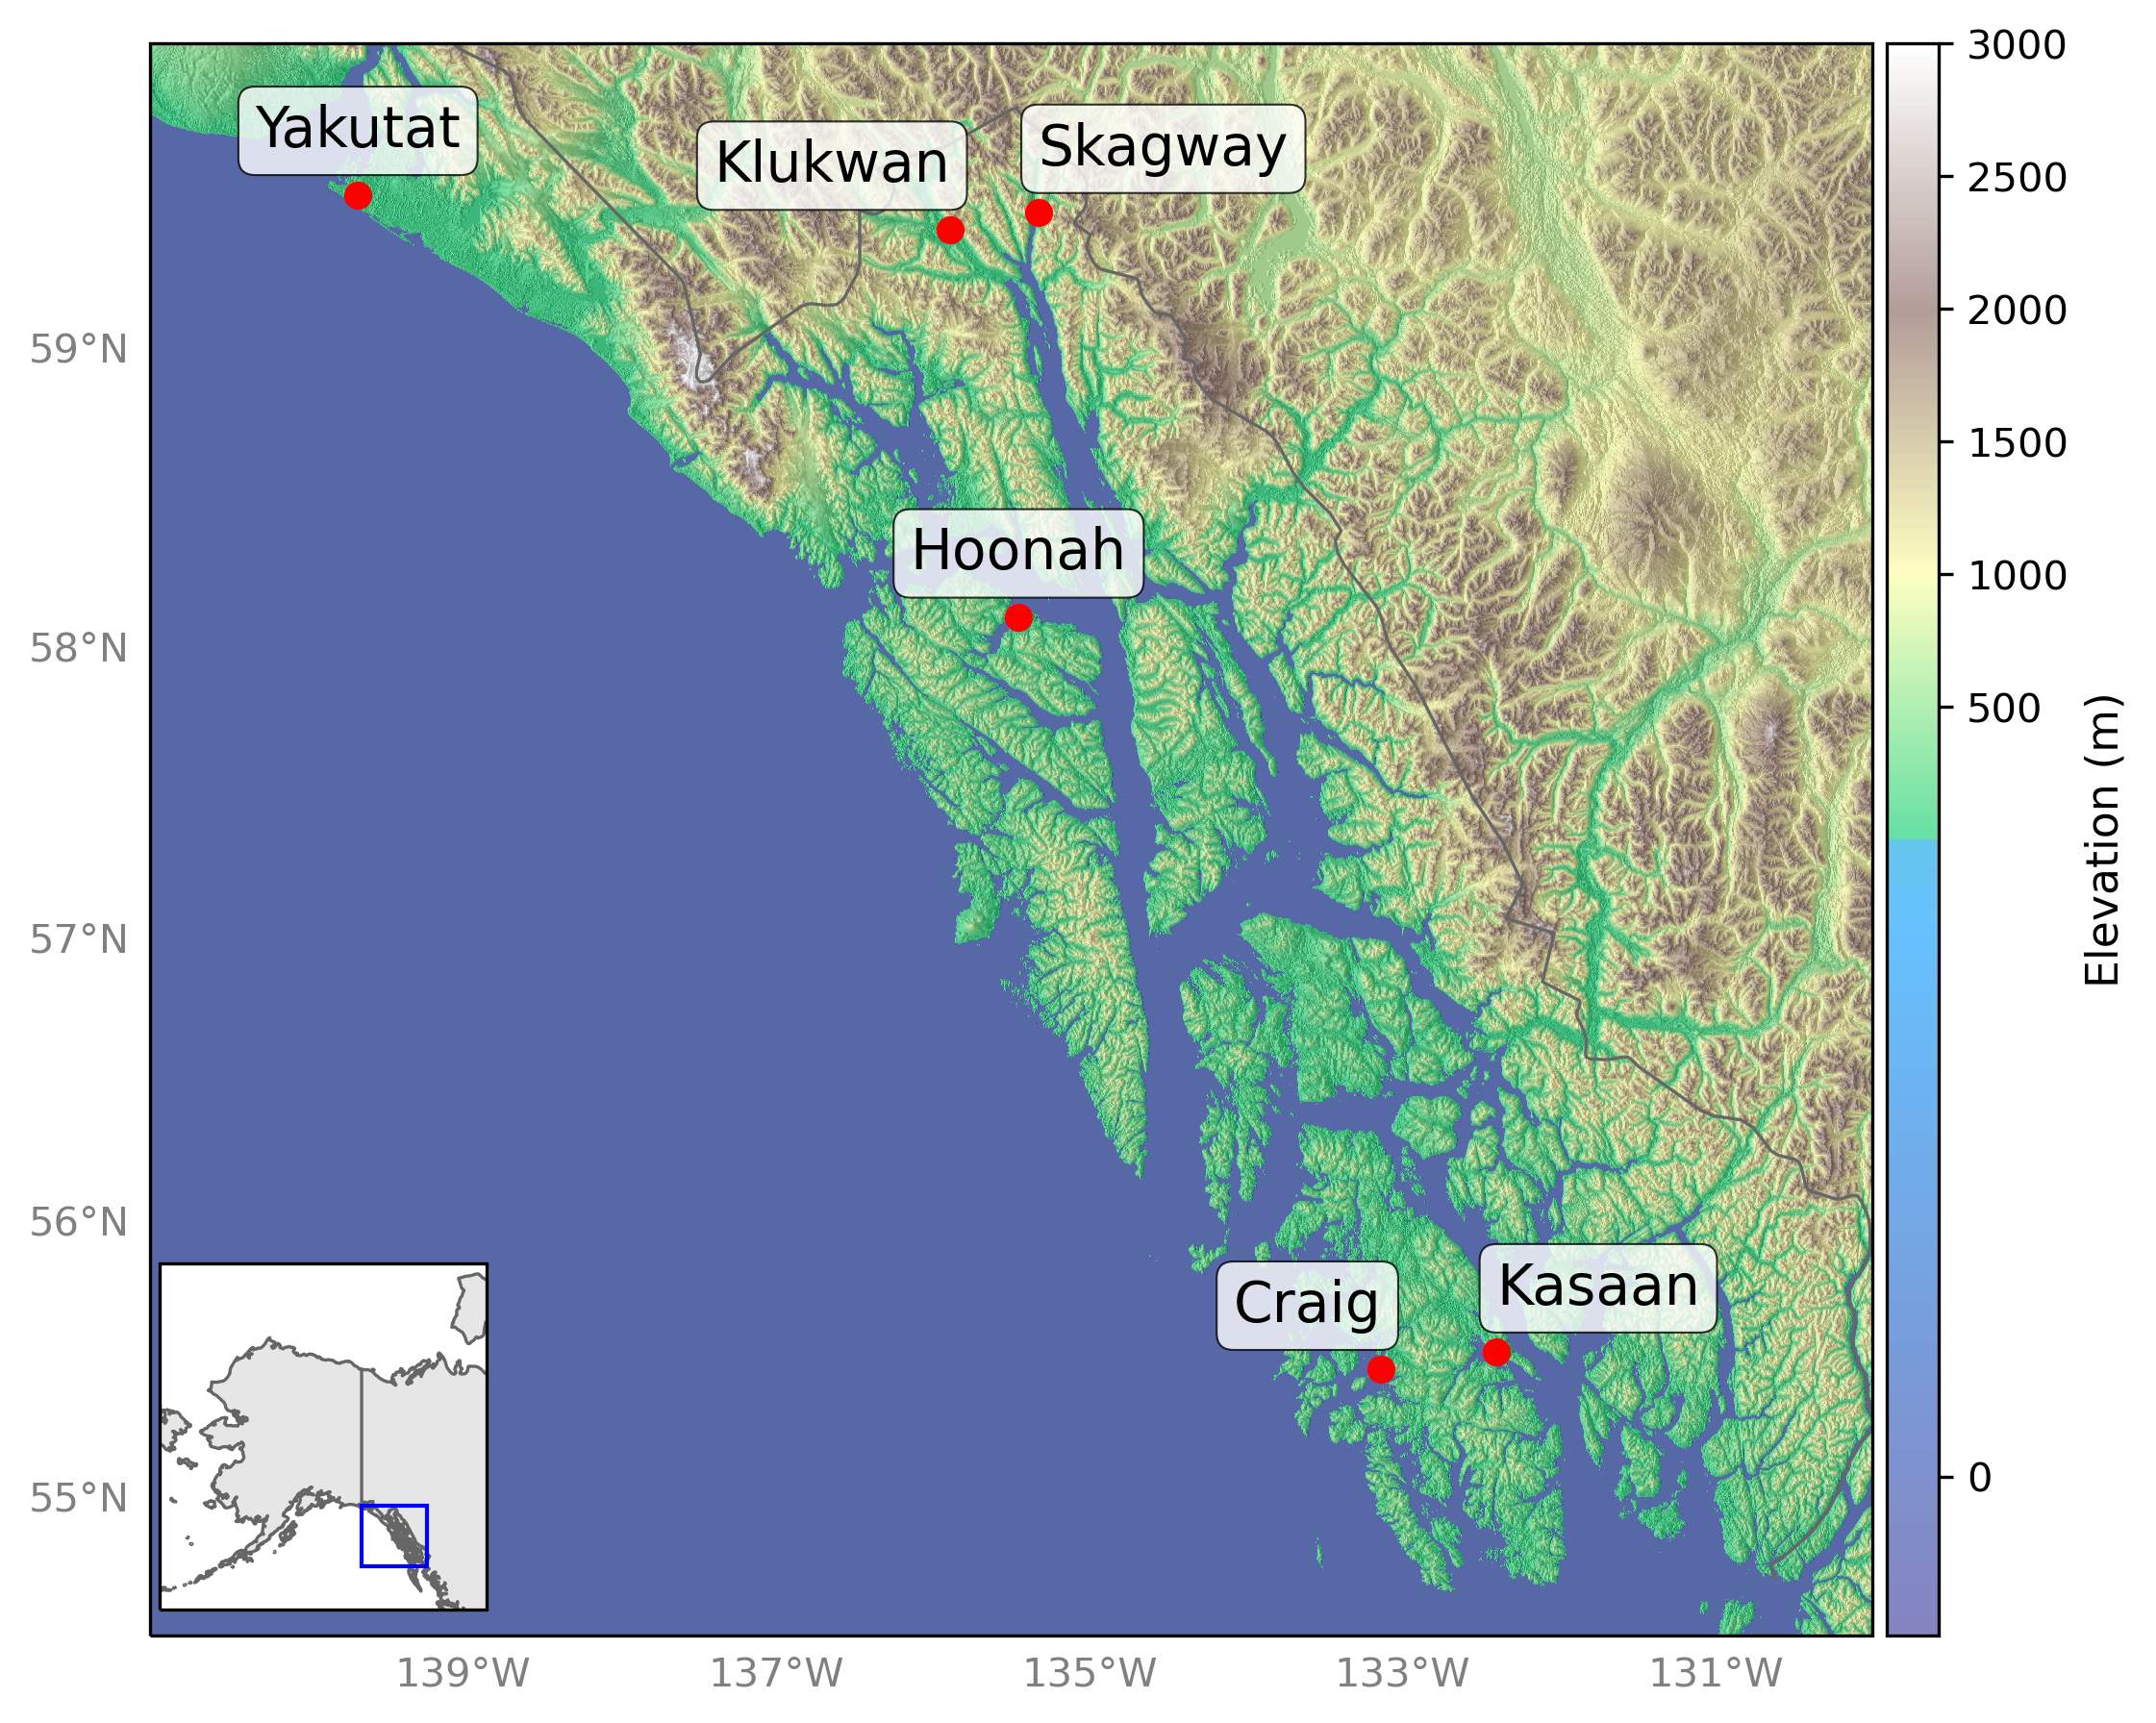

In [41]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'elevation_7.5arcsec_with_inset'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False, coastline=False)

    # topo with bright cmap

    cs = ax.pcolormesh(lons, lats, hillshade,
                        cmap=cmo.gray, transform=datacrs, alpha=0.7)
    
    cf = ax.pcolormesh(lons, lats, elev, rasterized=True, norm=divnorm,
                        cmap=terrain_map, shading='auto', transform=datacrs, alpha=0.6)
    
    
    # # add glaciers
    # ax.add_geometries(polys['geometry'], crs=crs_polys,
    #                   facecolor=(0.7, 1, 1, 0.7), ec=(0.1, 1, 1, 0),
    #                   zorder=100)
    
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=6, transform=datacrs)

        ax.annotate(z, # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,12), # distance from text to points (x,y)
                    ha=ha, # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                    xycoords=transform,
                    zorder=102,
                    fontsize=14)
        
#     ## Plot the locations of the precipitation stations
#     # zip joins x and y coordinates in pairs
#     for x,y,z,ha in zip(xs2,ys2, lbl2, lbl_align):

#         # Plot Location of DELHI radiosonde location
#         ax.plot(x, y, 'ko', markersize=4, transform=datacrs)

#         ax.annotate(z, # this is the text
#                      (x,y), # these are the coordinates to position the label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha=ha, # horizontal alignment can be left, right or center
#                      bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
#                      xycoords=transform,
#                      fontsize=9) 
    
    ### Add inset map  [left, bottom, width, height]
    axins = plt.axes([0.1, 0.2725, 0.2, 0.1], projection=mapcrs)
    axins.set_extent(ext2, crs=datacrs)
    # Add map features (continents and country borders)
    axins.add_feature(cfeature.LAND, facecolor='0.9')      
    axins.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
    axins.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)


    axins.add_patch(mpatches.Rectangle(xy=[ext1[0], ext1[2]], width=ext1[1]-ext1[0], height=ext1[3]-ext1[2],
                                        fill=False,
                                        edgecolor='b',
                                        linewidth=1.0,
                                        transform=datacrs,
                                        zorder=100))



# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('Elevation (m)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [20]:
ext_klukwan = [-136, -135.5, 59.25, 59.5] # extent of klukwan area
# Set tick/grid locations
diff = 0.1
dx = np.arange(ext_klukwan[0],ext_klukwan[1]+diff,diff)
dy = np.arange(ext_klukwan[2],ext_klukwan[3]+diff,diff)

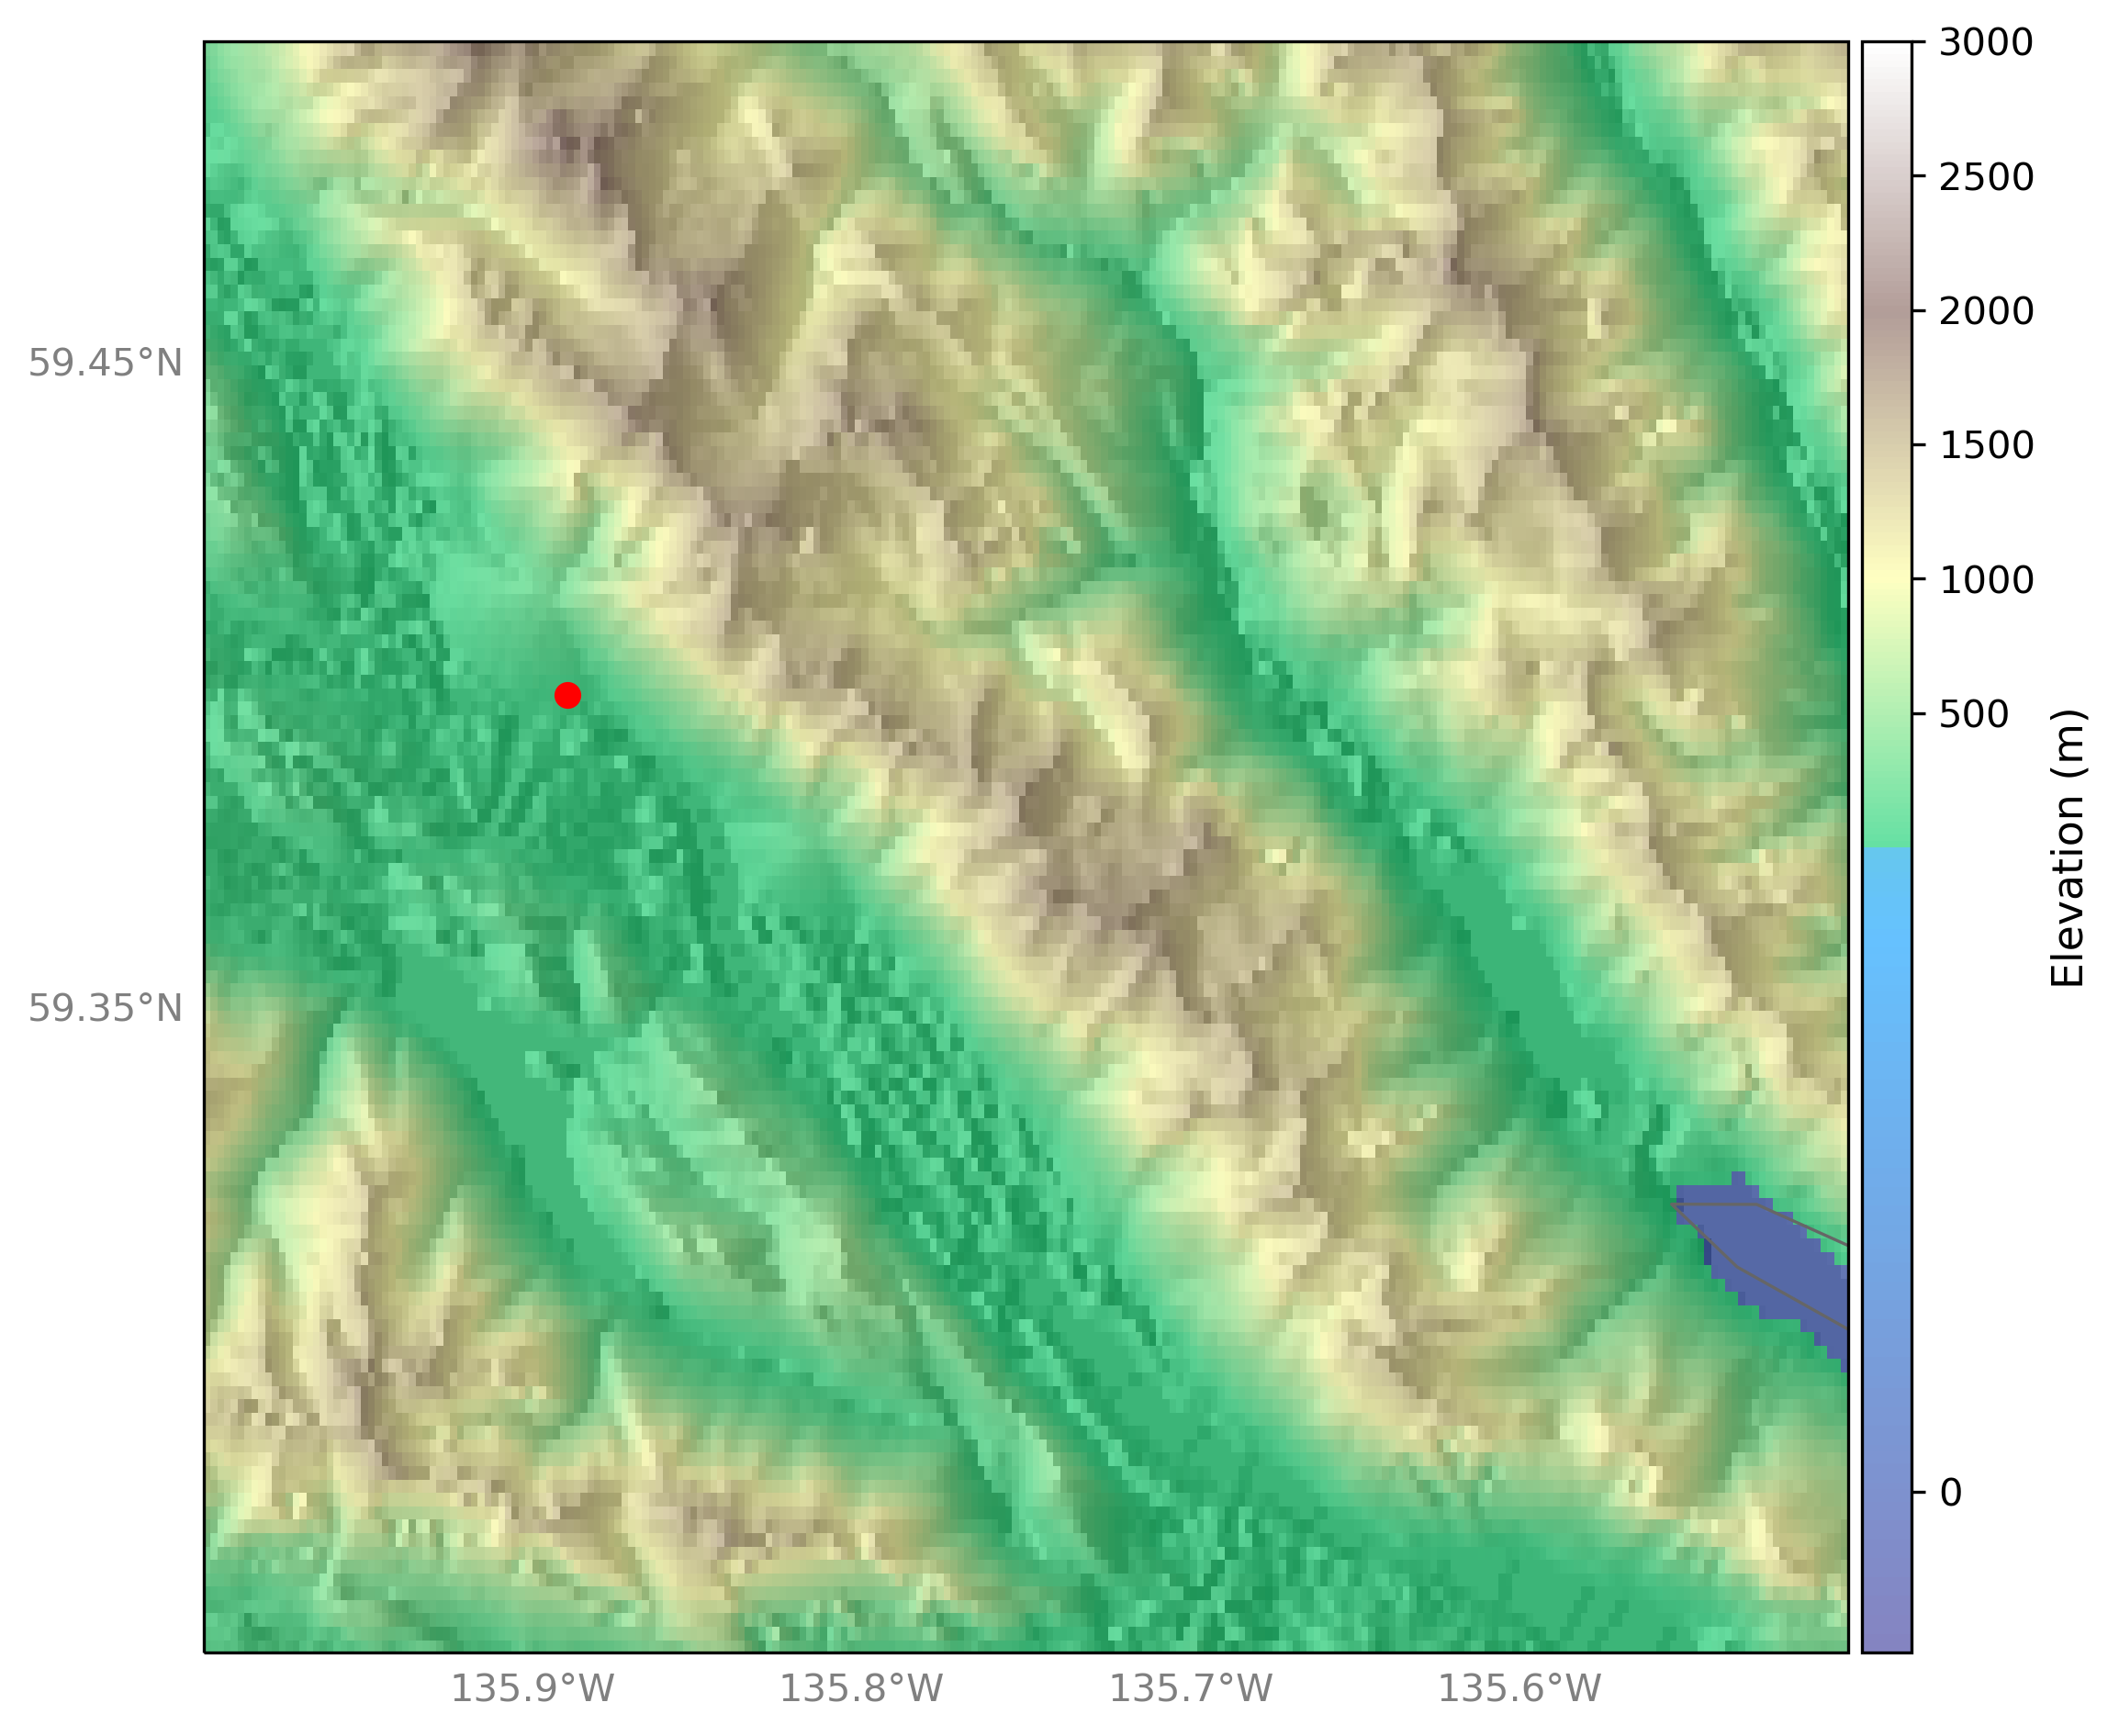

In [21]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'elevation_7.5arcsec_klukwan'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext_klukwan, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
    cs = ax.pcolormesh(lons, lats, hillshade,
                        cmap=cmo.gray, transform=datacrs, alpha=0.7)
    # topo with bright cmap
    cf = ax.pcolormesh(lons, lats, elev, rasterized=False, norm=divnorm,
                        cmap=terrain_map, shading='auto', transform=datacrs, alpha=0.6)
    
    ax.add_feature(cfeature.RIVERS)
    
    # # add glaciers
    # ax.add_geometries(polys['geometry'], crs=crs_polys,
    #                   facecolor=(0.7, 1, 1, 0.7), ec=(0.1, 1, 1, 0),
    #                   zorder=100)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=6, transform=datacrs)



# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('Elevation (m)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()